In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import re
import dill
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

Make sure sklearn is the latest version. An experimental function is used below.

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

In [3]:
import sklearn
sklearn.__version__

'1.0.1'

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [5]:
folder = '/content/drive/MyDrive/Colab_Notebooks/dpi_datascience_practical/ML/'

## Table of Contents

- [1 - Data Processing 1: Original Data](#1)
    - [1.0 Original Data Visualization: n_feature * 4 columns](#1-0)
    - [1.1 Estimating Model 1.1: Linear Regression (L2 penalty)](#1-1)
    - [1.2 Estimating Model 1.2: Linear Regression (L1 penalty)](#1-2)
    - [1.3 Estimating Model 1.3: Logistic Regression](#1-3)
    - [1.4 Estimating Model 1.4: Random Forest Classifier](#1-4)
- [2 - Data Processing 2](#2)
    - [2.0 Data Imbalance and Analysis](#2-0)
    - [2.1 Estimating Model 2.1: Logistic Regression](#2-1)
        - [2.1.1 Turn Off `state`](#2-1-1)
        - [2.1.2 Turn Off `age`](#2-1-2)
        - [2.1.3 Turn Off `state` and `age`](#2-1-3)
    - [2.2 Estimating Model 2.2: random forest classifier](#2-2)
        - [2.2.1 Turn Off `state`](#2-2-1)
        - [2.2.2 Turn Off `age`](#2-2-2)
        - [2.2.3 Turn Off `state` and `age`](#2-2-3)
- [3 - Model Analysis](#3)
    - [3.0 Model Choosing](#3-0)
    - [3.1 Feature Analysis](#3-1)
- [4 - Conclusion](#4[link text](https://))

Load data.

In [79]:
df = pd.read_csv(folder+'ds_practical.txt',sep='|')

Each `anon_person_id` from 1 to 500 appears twice. **Assume** they are redundant and remove them.

In [80]:
df = df.iloc[:999500]

<a name='1'></a>
## 1.   Data Processing 1: Original Data


- Use the original full data, only remove some null data in `age` column, replace 'feMalee' in the gender column is 'Female', and fill the null data in `state` column with 'CA' (due to the overwhelming majority (~99%) case of 'CA')


- one-hot encode categorical features, scalize numerical features

In [81]:
df.dropna(subset=['age'], inplace=True)

Almost all (98.7%) the users here come from CA

In [82]:
df.state.value_counts(normalize=True)

CA    0.986993
GA    0.010932
DC    0.002075
Name: state, dtype: float64

In [83]:
df.fillna(value={'state': 'CA'}, inplace=True)

**Assume** 'feMalee' in the `gender` column is 'Female', because the document says the values for this column is either Male or Female

In [84]:
df.gender.unique()

array(['Female', 'Male', 'feMalee'], dtype=object)

In [85]:
df.gender.replace({'feMalee': 'Female'}, inplace=True)

<a name='1-0'></a>
### 1.0.  Original Data Visualization: n_feature * 4 columns


The 4 columns are:


1.   In each feature, the distribution of positive case (target=1) and negative case (target=0) at different values

1.   In each feature, the distribution of values corresponding to negative case (target=0)

1.   In each feature, the distribution of values corresponding to positive case (target=1)

1.   In each feature, the distribution of values in the whole data set.

In [270]:
categorical_columns = ['state', 'presence_of_child_ind', 'streaming_media_subs', 
                       'streaming_entertainment_subs', 'marital_status', 'gender', 'income']
numerical_columns = ['number_of_news_subs', 'age']

Plot categorical features.

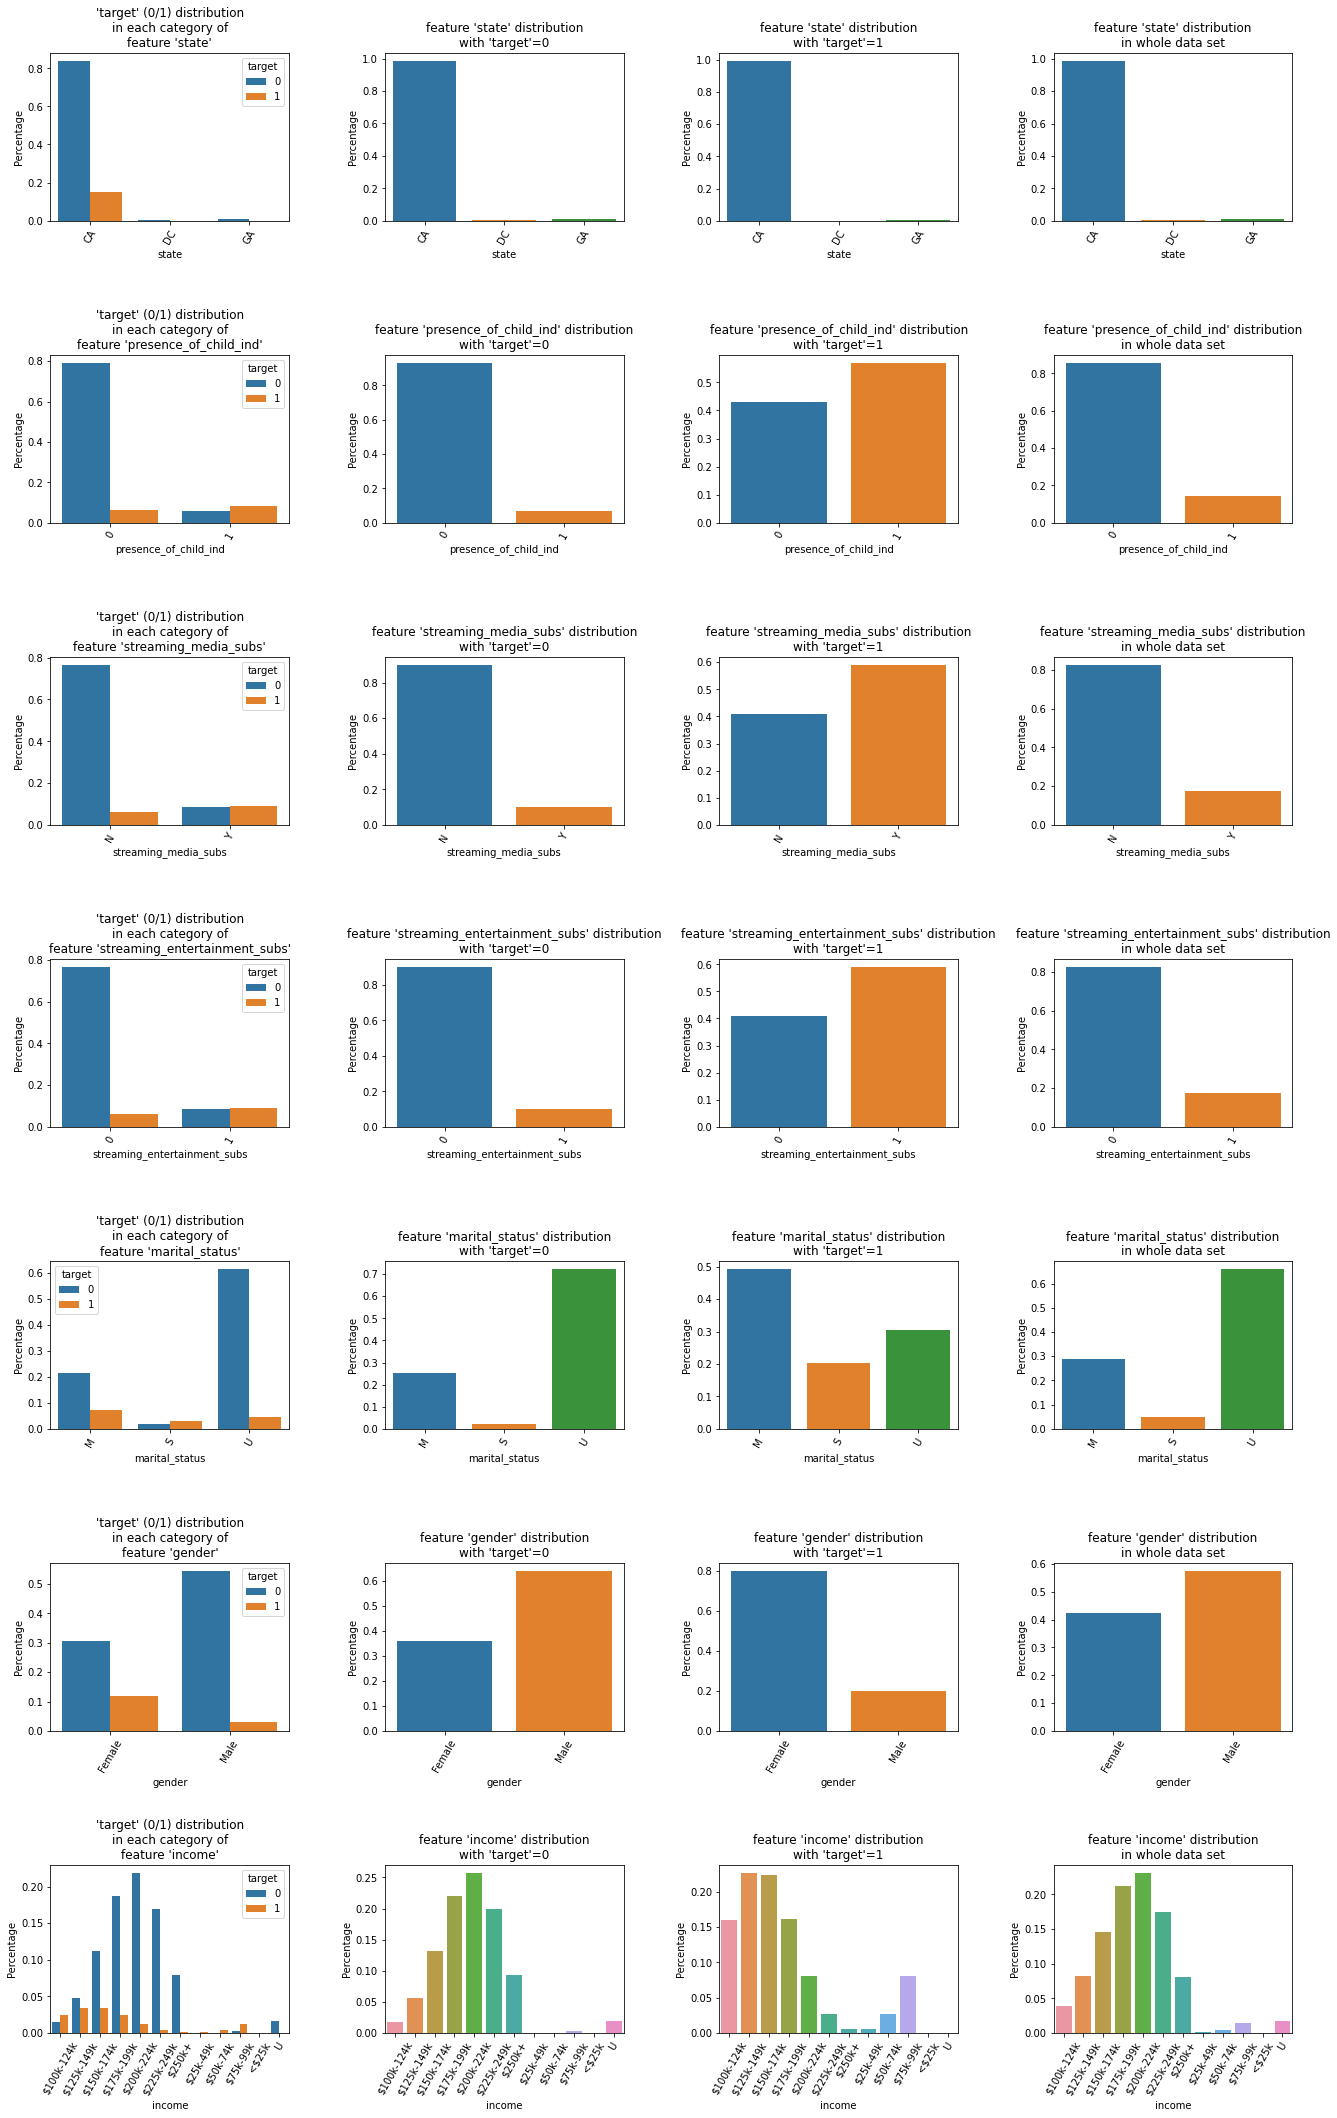

In [87]:
xtickrot = 60
ax = {}
for ind, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 4, ind * 4 + 1)
    d0 = df[['target',column]].value_counts(normalize=True).\
                               reset_index().rename(columns={0: "y"})
    ax[0] = sns.barplot(x=column,y='y', hue='target', data=d0, 
                        order=sorted(set(d0[column])))
    ax[0].axes.set_title(
        f"'target' (0/1) distribution\nin each category of\nfeature '{column}'"
        )

    plt.subplot(len(categorical_columns), 4, ind * 4 + 2)
    d1 = df[df.target == 0][column].value_counts(normalize=True).reset_index()
    ax[1] = sns.barplot(x='index',y=column, data=d1,
                        order=sorted(set(d0[column])))
    ax[1].axes.set_title(f"feature '{column}' distribution\nwith 'target'=0")

    plt.subplot(len(categorical_columns), 4, ind * 4 + 3)
    d2 = df[df.target == 1][column].value_counts(normalize=True).reset_index()
    ax[2] = sns.barplot(x='index',y=column, data=d2,
                        order=sorted(set(d0[column])))
    ax[2].axes.set_title(f"feature '{column}' distribution\nwith 'target'=1")

    plt.subplot(len(categorical_columns), 4, ind * 4 + 4)
    d3 = df[column].value_counts(normalize=True).reset_index()
    ax[3] = sns.barplot(x='index',y=column, data=d3,
                        order=sorted(set(d0[column])))
    ax[3].axes.set_title(f"feature '{column}' distribution\nin whole data set")
    
    for i in range(4):
        ax[i].set_xlabel(column)
        ax[i].set_ylabel('Percentage')
        ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = xtickrot)

    plt.subplots_adjust(right=3, top=7, wspace=.4, hspace=.8)

Plot numerical features.

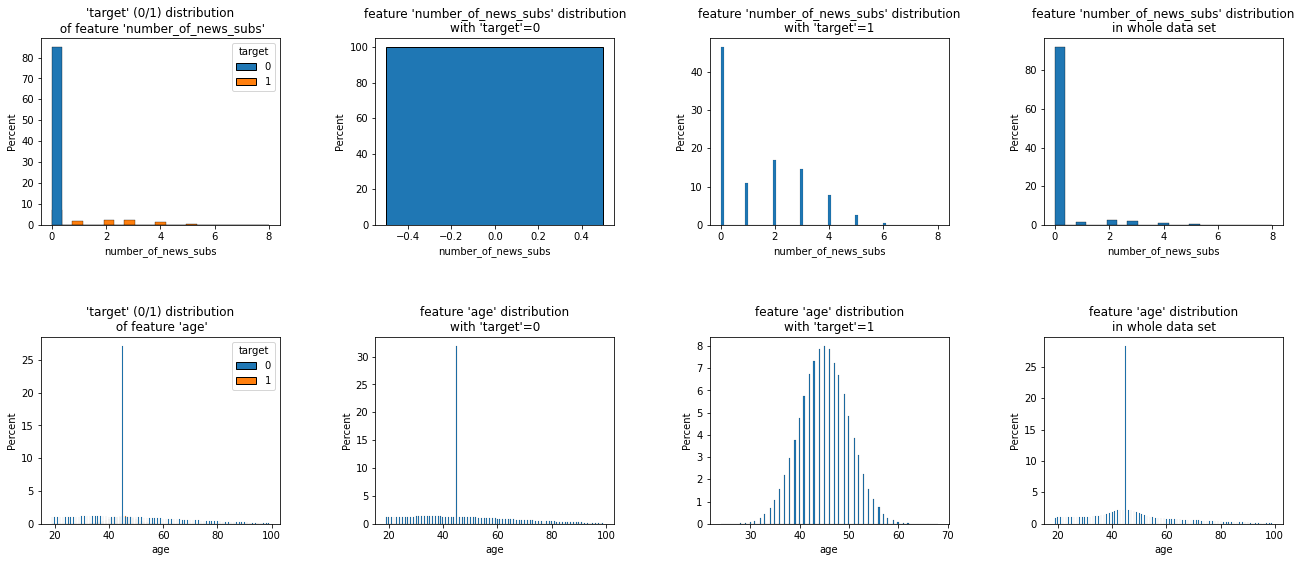

In [14]:
for ind, column in enumerate(numerical_columns):
    plt.subplot(len(categorical_columns), 4, ind * 4 + 1)
    d0 = df[['target',column]]
    ax[0] = sns.histplot(x=column, hue='target', data=d0, stat='percent', alpha=1)
    ax[0].axes.set_title(
        f"'target' (0/1) distribution\n of feature '{column}'"
        )

    plt.subplot(len(categorical_columns), 4, ind * 4 + 2)
    d1 = df[df.target == 0][[column]]
    ax[1] = sns.histplot(x=column, data=d1, stat='percent', alpha=1)
    ax[1].axes.set_title(f"feature '{column}' distribution\nwith 'target'=0")

    plt.subplot(len(categorical_columns), 4, ind * 4 + 3)
    d2 = df[df.target == 1][[column]]
    ax[2] = sns.histplot(x=column, data=d2, stat='percent', alpha=1)
    ax[2].axes.set_title(f"feature '{column}' distribution\nwith 'target'=1")

    plt.subplot(len(categorical_columns), 4, ind * 4 + 4)
    d3 = df[[column]]
    ax[3] = sns.histplot(x=column, data=d3, stat='percent', alpha=1)
    ax[3].axes.set_title(f"feature '{column}' distribution\nin whole data set")

    plt.subplots_adjust(right=3, top=7, wspace=.4, hspace=.6)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], random_state=42)

<a name='1-1'></a>
### 1.1.  Estimating Model 1.1: Linear Regression (L2 penalty)

In [105]:
column_transformer = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numerical', MinMaxScaler(), numerical_columns)
])
model_11 = Pipeline([
    ('column_transformer', column_transformer),
    ('regressor', Ridge(alpha=3))
])
# model_11.get_params()

In [106]:
param_grid = {"regressor__alpha": [.1, .3, 1, 3, 10]}
model_11_search = HalvingGridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=-1)\
        .fit(X_train, y_train)
model_11_search.best_params_  

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'regressor__alpha': 3}

In [69]:
print('training score', model_11_search.score(X_train, y_train))
print('testing score', model_11_search.score(X_test, y_test))

training score 0.5756019631488907
testing score 0.5743096279126849


In [264]:
model_11_search.best_estimator_.named_steps['regressor'].coef_

array([ 0.02741359, -0.02571425, -0.00169934, -0.09357539,  0.09357539,
       -0.05891328,  0.05891328, -0.05891328,  0.05891328, -0.02796979,
        0.1483147 , -0.1203449 ,  0.05391907, -0.05391907, -0.03928723,
       -0.09234809,  0.07030337,  0.02472556, -0.02193926, -0.04462508,
       -0.05521364,  0.08423138,  0.05700666,  0.02533846,  0.04816785,
       -0.05635995,  1.412259  , -0.04191211])

In [314]:
model_11_search.best_estimator_.named_steps['regressor'].intercept_


0.34402174875285707

In [110]:
with open(folder+'model_11.pickle', 'wb') as f11a:
    dill.dump(model_11, f11a)
with open(folder+'model_11_search.pickle', 'wb') as f11b:
    dill.dump(model_11_search, f11b)    

The L2 regulated linear regression is fair. The score shows that the direct linear correlation among the features is week. Not a good model.

<a name='1-2'></a>
### 1.2.  Estimating Model 1.2: Linear Regression (L1 penalty)

In [ ]:
model_12 = Pipeline([
    ('column_transformer', column_transformer),
    ('regressor', Lasso())
])
# model_12.get_params()

In [259]:
param_grid = {"regressor__alpha": [.1, .3, 1, 3, 10]}
model_12_search = HalvingGridSearchCV(estimator=model_12, param_grid=param_grid, n_jobs=-1)\
        .fit(X_train, y_train)
model_12_search.best_params_ 

{'regressor__alpha': 3}

In [260]:
print('training score', model_12_search.score(X_train, y_train))
print('testing score', model_12_search.score(X_test, y_test))

training score 0.0
testing score -8.506640220451445e-06


In [263]:
model_12_search.best_estimator_.named_steps['regressor'].coef_

array([ 0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0., -0.,
        0., -0.])

In [312]:
model_12_search.best_estimator_.named_steps['regressor'].intercept_

0.14998013400025037

In [114]:
# with open(folder+'model_12.pickle', 'wb') as f12a:
#     dill.dump(model_12, f12a)
# with open(folder+'model_12_search.pickle', 'wb') as f12b:
#     dill.dump(model_12_search, f12b)    

The L1 regulated linear regression is not good. It besically concluds that not any feature is important, and the 'best' model is a constant 0.15, which is obviously a bad model.

<a name='1-3'></a>
### 1.3.   Estimating Model 1.3: Logistic Regression





In [90]:
model_13 = Pipeline([
    ('column_transformer', column_transformer),
    ('regressor', LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        n_jobs=-1,
        random_state=42))
])
# model_13.get_params()

In [93]:
param_grid = {'regressor__C': [.3, 1, 3],
              'regressor__l1_ratio': [0, 0.33, 0.66, 1]}
model_13_search = HalvingGridSearchCV(estimator=model_13, param_grid=param_grid, n_jobs=-1)\
        .fit(X_train, y_train)
model_13_search.best_params_  

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


{'regressor__C': 3, 'regressor__l1_ratio': 1}

In [94]:
print('training score', model_13_search.score(X_train, y_train))
print('testing score', model_13_search.score(X_test, y_test))

training score 0.9498029728244008
testing score 0.9500683743239106


Pretty good result! It basically uses a logistic regression with a pure L1 penalty and a mild (1/3) regulatization.

In [283]:
categorical_columns_categories = model_13_search\
                                .best_estimator_\
                                .named_steps['column_transformer']\
                                .named_transformers_['categorical']\
                                .categories_

In [325]:
logistic_regression_coef = model_13_search.best_estimator_.named_steps['regressor'].coef_

In [330]:
logistic_regression_coef

array([[ 0.67490162, -0.96711567,  0.        , -3.62896547,  3.08503305,
        -0.91333943,  0.37010945, -0.91333943,  0.37010945,  0.        ,
         1.52567083, -1.53937893,  0.70302507, -1.24688407, -3.45687545,
        -4.10583537,  4.03596205,  3.56906608,  2.73513607,  1.87645076,
         0.97783095, -0.97787468, -1.61581235, -2.5383902 , -1.335681  ,
         0.31769862, 83.54481332, -0.92314138]])

In [336]:
feature_coef = {}
i_c = 0
for i_f, feature in enumerate(categorical_columns):
    for category in categorical_columns_categories[i_f]:
        feature_coef['_'.join([feature, str(category)])] \
            = logistic_regression_coef[0, i_c]
        i_c += 1
for i_f, feature in enumerate(numerical_columns):
    feature_coef[feature] = logistic_regression_coef[0, i_f - 2]

In [337]:
pd.Series(feature_coef).to_frame()\
        .reset_index()\
        .rename(columns={'index': 'feature_category', 0:'coef'})

,feature_category,coef
0,state_CA,0.674902
1,state_DC,-0.967116
2,state_GA,0.000000
3,presence_of_child_ind_0,-3.628965
4,presence_of_child_ind_1,3.085033
5,streaming_media_subs_N,-0.913339
6,streaming_media_subs_Y,0.370109
7,streaming_entertainment_subs_0,-0.913339
8,streaming_entertainment_subs_1,0.370109
9,marital_status_M,0.000000


In [302]:
# with open(folder+'model_13.pickle', 'wb') as f13a:
#     dill.dump(model_13, f13a)
# with open(folder+'model_13_search.pickle', 'wb') as f13b:
#     dill.dump(model_13_search, f13b)    

This model works pretty well. Notice that `number_of_news_subs` has very strong impact on the result. Other features will be discussed in the conclusion section.

<a name='1-4'></a>
### 1.4.  Estimating Model 1.4: Random Forest Classifier

In [98]:
model_14 = Pipeline([
    ('column_transformer', column_transformer),
    ('regressor', RandomForestClassifier(
        n_jobs=-1,
        random_state=42))
])
# model_14.get_params()

In [99]:
param_grid_no_bootstrap = {'regressor__n_estimators': [100, 300],
                           'regressor__max_depth': [100, 300, None]}
model_14_no_bootstrap_search = HalvingGridSearchCV(estimator=model_14, 
                                                   param_grid=param_grid_no_bootstrap,
                                                   n_jobs=-1)\
        .fit(X_train, y_train)
model_14_no_bootstrap_search.best_params_ 

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'regressor__max_depth': 300, 'regressor__n_estimators': 300}

In [100]:
print('training score', model_14_no_bootstrap_search.score(X_train, y_train))
print('testing score', model_14_no_bootstrap_search.score(X_test, y_test))

training score 0.9629499104669327
testing score 0.9614532095111746


In [346]:
randomforestregression_feature_importances = model_14_no_bootstrap_search\
                                        .best_estimator_['regressor']\
                                        .feature_importances_

In [347]:
randomforestregression_feature_importances

array([2.96372488e-04, 1.14589503e-04, 2.36894308e-04, 6.87417355e-02,
       7.75733353e-02, 5.02681433e-02, 4.78371307e-02, 4.20580786e-02,
       5.18952397e-02, 1.32650537e-02, 2.72671156e-02, 4.16002325e-02,
       3.94436583e-02, 3.62182737e-02, 4.91807842e-03, 6.25019886e-03,
       1.53813316e-02, 5.53895163e-03, 3.55798414e-03, 7.64427856e-03,
       5.45940394e-03, 1.55334232e-04, 9.01022835e-04, 3.92893499e-03,
       1.24489952e-05, 1.19726455e-03, 3.14690399e-01, 1.33548515e-01])

In [348]:
feature_importances = {}
i_c = 0

for i_f, feature in enumerate(categorical_columns):
    for category in categorical_columns_categories[i_f]:
        feature_importances['_'.join([feature, str(category)])] \
        = randomforestregression_feature_importances[i_c]
        i_c += 1

for i_f, feature in enumerate(numerical_columns):
    feature_importances[feature] = randomforestregression_feature_importances[i_f - 2]

In [349]:
pd.Series(feature_importances)\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index': 'feature_category',
                         0:'feature_importance'})

,feature_category,feature_importance
0,state_CA,0.000296
1,state_DC,0.000115
2,state_GA,0.000237
3,presence_of_child_ind_0,0.068742
4,presence_of_child_ind_1,0.077573
5,streaming_media_subs_N,0.050268
6,streaming_media_subs_Y,0.047837
7,streaming_entertainment_subs_0,0.042058
8,streaming_entertainment_subs_1,0.051895
9,marital_status_M,0.013265


In [371]:
pd.DataFrame(model_14_no_bootstrap_search.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,244974,19.882386,1.654005,1.106639,0.127672,100,100,"{'regressor__max_depth': 100, 'regressor__n_es...",0.959648,0.960199,0.961893,0.962322,0.960118,0.960836,0.001064,6,0.964231,0.964537,0.964088,0.963710,0.964629,0.964239,0.000330
1,0,244974,56.977237,3.087114,2.955964,0.083762,100,300,"{'regressor__max_depth': 100, 'regressor__n_es...",0.959771,0.960383,0.962097,0.962363,0.960138,0.960950,0.001066,3,0.964231,0.964542,0.964088,0.963716,0.964629,0.964241,0.000329
2,0,244974,19.643893,1.551183,1.194181,0.052293,300,100,"{'regressor__max_depth': 300, 'regressor__n_es...",0.959648,0.960199,0.961893,0.962322,0.960118,0.960836,0.001064,6,0.964231,0.964537,0.964088,0.963710,0.964629,0.964239,0.000330
3,0,244974,56.408426,1.908778,3.018754,0.097111,300,300,"{'regressor__max_depth': 300, 'regressor__n_es...",0.959771,0.960383,0.962097,0.962363,0.960138,0.960950,0.001066,3,0.964231,0.964542,0.964088,0.963716,0.964629,0.964241,0.000329
4,0,244974,19.548899,1.258377,1.102721,0.057429,None,100,"{'regressor__max_depth': None, 'regressor__n_e...",0.959648,0.960199,0.961893,0.962322,0.960118,0.960836,0.001064,6,0.964231,0.964537,0.964088,0.963710,0.964629,0.964239,0.000330
5,0,244974,51.843849,10.737925,2.651539,0.641490,None,300,"{'regressor__max_depth': None, 'regressor__n_e...",0.959771,0.960383,0.962097,0.962363,0.960138,0.960950,0.001066,3,0.964231,0.964542,0.964088,0.963716,0.964629,0.964241,0.000329
6,1,734922,271.436615,18.625259,7.924117,0.175324,300,300,"{'regressor__max_depth': 300, 'regressor__n_es...",0.962166,0.961744,0.961227,0.961799,0.961104,0.961608,0.000391,1,0.962930,0.963049,0.963205,0.962977,0.963200,0.963072,0.000113
7,1,734922,280.605042,9.720470,7.975652,0.408039,None,300,"{'regressor__max_depth': None, 'regressor__n_e...",0.962166,0.961744,0.961227,0.961799,0.961104,0.961608,0.000391,1,0.962930,0.963049,0.963205,0.962977,0.963200,0.963072,0.000113


In [116]:
# with open(folder+'model_14.pickle', 'wb') as f14a:
#     dill.dump(model_14, f14a)
# with open(folder+'model_14_no_bootstrap_search.pickle', 'wb') as f14b:
#     dill.dump(model_14_no_bootstrap_search, f14b)    

<a name='2'></a>
## 2.   Data Processing 2

<a name='2-0'></a>
### 2.0.  Data Imbalance and Analysis


The original is **imbalanced**. This is based on the **assumption** that the future data of 'PodNN' will be more balanced, or we want the audience to be more diverse. In other words, it is **assumed** that the current data is *not* representative to the (expected) future data.

Below, some brief analyses are listed.


1.   `state`


> - Most data (~99%) are collected in CA. Assume that the new 'PodNN' is a nationa-wide program. The result shown in this data will mostly reflect the audience behaviors who live in CA.

> - The fact that most data are collected in CA also potentially introduces other biases, e.g. race, education level, occupation, political leaning, etc.

> - If possible (despite the time and price to pay), the current survey data need to collect more data from other states. 

> - When analysizing this data set, an optional option is to turn off this feature, given that CA is the overwhelming majority (~99%) case, and in DC (0.2% of total) and GA (1.1% of tatol) cases only 2.9% and 8.6 %.


2.   `presence_of_chile_ind`, `streaming_media_subs` and `streaming_entertainment_subs`

> - Hard to say these three features have extreme imbalence problems. The data distribute similarly in these three features. But it should be kept in mind that negative (target=0) cases account 80% of the total data.


3.   `number_of_news_subs`

> - This feature also has overwhelmingly majority of value 0. Note that in the negative (target=0) pool, 100% of people have 0 subsciption of news; in the positive (target=1) pool, majority of people (~50%) have 0 subsciption of news. This feature may not have much importance.


4.   `age`

> - There is an obvious singularity at age 45 (~28% of total), while other ages are ~1% - 2%. 

> - One possibility could be that there is some mistake in this data set. If this is true, it needs to be fixed. Otherwise, we can simply drop this feature since it may not have very strong impact on result. Models need to run to check on it.

> - If the mistake is from surveying, say the survey happened to occur at the 45-year-old club (which is odd). To fix it, one option is to apply weight on observations when calculating cost function to balance out the singular frequncy. Other options include over-sampling other ages (the con is to generate a lot of redundant data), or under-sampling age 45 samples (the con is to waste data).

> - If the age data is correct, then somehow there are indeed many people at 45 year-old correcly surveyed, which is of course not true in real world. Again, turning off this feature might be a good idea.

Start from the original data.

In [8]:
df2 = pd.read_csv(folder+'ds_practical.txt',sep='|')
df2 = df2.iloc[:999500]
df2.dropna(subset=['age'], inplace=True)
df2.gender.replace({'feMalee': 'Female'}, inplace=True)

Remove the `state` and/or `age` feature.

In [9]:
categorical_columns_no_state = ['presence_of_child_ind', 'streaming_media_subs', 
                       'streaming_entertainment_subs', 'marital_status', 'gender', 'income']
numerical_columns_no_age = ['number_of_news_subs']

In [11]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
                                            df2.drop(columns=['target']), 
                                            df2['target'], 
                                            random_state=42)

<a name='2-1'></a>
### 2.1.  Estimating Model 2.1: Logistic Regression

In [398]:
def print_feature_importance(model, regressor):
    """
    This function is to print the coefficients (logistic regression) or
    feature importances (random forest classifier) for each feature.
    """
    categorical_columns_categories = model\
                                    .named_steps['column_transformer']\
                                    .named_transformers_['categorical']\
                                    .categories_
    
    categorical_columns = model\
                        .named_steps['column_transformer']\
                        .named_transformers_['categorical']\
                        .feature_names_in_
    
    numerical_columns = model\
                        .named_steps['column_transformer']\
                        .named_transformers_['numerical']\
                        .feature_names_in_

    if regressor == 'log':
        cls_feature_importance = model.named_steps['regressor']\
                                    .coef_\
                                    .reshape(-1)
    elif regressor == 'rfc':
        cls_feature_importance = model.named_steps['regressor']\
                                    .feature_importances_\
                                    .reshape(-1)
    
    feature_coef = {}
    i_c = 0
    for i_f, feature in enumerate(categorical_columns):
        for category in categorical_columns_categories[i_f]:
            feature_coef['_'.join([feature, str(category)])] \
                = cls_feature_importance[i_c]
            i_c += 1
    for i_f, feature in enumerate(numerical_columns):
        feature_coef[feature] = cls_feature_importance[i_f - len(numerical_columns)]

    df = pd.Series(feature_coef)\
            .to_frame()\
            .reset_index()\
            .rename(columns={'index': 'feature_category',
                             0:'feature_importance'})
    return df

<a name='2-1-1'></a>
#### 2.1.1.  Turn Off `state`

In [379]:
column_transformer_no_state = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns_no_state),
    ('numerical', MinMaxScaler(), numerical_columns)
])
# keep C=3, l1_ratio=1 from the first section
model_211_no_state = Pipeline([
    ('column_transformer', column_transformer_no_state),
    ('regressor', LogisticRegression(
        C=3,
        l1_ratio=1,
        solver='saga',
        penalty='elasticnet',
        n_jobs=-1,
        random_state=42))
])
model_211_no_state.fit(X2_train, y2_train)
print('training score', model_211_no_state.score(X2_train, y2_train))
print('testing score', model_211_no_state.score(X2_test, y2_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


training score 0.9498179403584588
testing score 0.950076538422288


In [405]:
# with open(folder+'model_211_no_state.pickle', 'wb') as f211:
#     dill.dump(model_211_no_state, f211)

In [399]:
print_feature_importance(model_211_no_state, 'log')

,feature_category,feature_importance
0,presence_of_child_ind_0,-3.535846
1,presence_of_child_ind_1,3.227918
2,streaming_media_subs_N,-0.795399
3,streaming_media_subs_Y,0.487719
4,streaming_entertainment_subs_0,-0.795399
5,streaming_entertainment_subs_1,0.487719
6,marital_status_M,0.000000
7,marital_status_S,1.535703
8,marital_status_U,-1.537495
9,gender_Female,0.822346


<a name='2-1-2'></a>
#### 2.1.2.  Turn Off `age`

In [380]:
column_transformer_no_age = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numerical', MinMaxScaler(), numerical_columns_no_age)
])
# keep C=3, l1_ratio=1 from the first section
model_212_no_age = Pipeline([
    ('column_transformer', column_transformer_no_age),
    ('regressor', LogisticRegression(
        C=3,
        l1_ratio=1,
        solver='saga',
        penalty='elasticnet',
        n_jobs=-1,
        random_state=42))
])
model_212_no_age.fit(X2_train, y2_train)
print('training score', model_212_no_age.score(X2_train, y2_train))
print('testing score', model_212_no_age.score(X2_test, y2_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


training score 0.9489021994110955
testing score 0.9492274721910399


In [406]:
# with open(folder+'model_212_no_age.pickle', 'wb') as f212:
#     dill.dump(model_212_no_age, f212)

In [400]:
print_feature_importance(model_212_no_age, 'log')

,feature_category,feature_importance
0,state_CA,0.747143
1,state_DC,-0.742763
2,state_GA,0.027898
3,state_nan,-0.904883
4,presence_of_child_ind_0,-3.904960
5,presence_of_child_ind_1,2.866546
6,streaming_media_subs_N,-1.153145
7,streaming_media_subs_Y,0.129784
8,streaming_entertainment_subs_0,-1.153145
9,streaming_entertainment_subs_1,0.129784


<a name='2-1-3'></a>
#### 2.1.3.  Turn Off `state` and `age`

In [381]:
column_transformer_no_state_age = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns_no_state),
    ('numerical', MinMaxScaler(), numerical_columns_no_age)
])
# keep C=3, l1_ratio=1 from the first section
model_213_no_state_age = Pipeline([
    ('column_transformer', column_transformer_no_state_age),
    ('regressor', LogisticRegression(
        C=3,
        l1_ratio=1,
        solver='saga',
        penalty='elasticnet',
        n_jobs=-1,
        random_state=42))
])
model_213_no_state_age.fit(X2_train, y2_train)
print('training score', model_213_no_state_age.score(X2_train, y2_train))
print('testing score', model_213_no_state_age.score(X2_test, y2_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


training score 0.9487851805084607
testing score 0.9491009286661904


In [407]:
# with open(folder+'model_213_no_state_age.pickle', 'wb') as f213:
#     dill.dump(model_213_no_state_age, f213)

In [13]:
# with open(folder+'model_213_no_state_age.pickle', 'rb') as f213:
#     model_213_no_state_age = dill.load(f213)

In [35]:
data = {'anon_person_id': df2.anon_person_id.values, 
        'target': df2.target.values, 
        'predict': model_213_no_state_age.predict(df2.drop(columns=['target'])),
        'probability': model_213_no_state_age.predict_proba(df2.drop(columns=['target'])).max(axis=1)}
final_model_score = pd.DataFrame(data, 
                                 columns=['anon_person_id', 'target', 
                                          'predict', 'probability'])

In [41]:
final_model_score.to_csv(folder+'Score.csv')

In [401]:
print_feature_importance(model_213_no_state_age, 'log')

,feature_category,feature_importance
0,presence_of_child_ind_0,-3.734562
1,presence_of_child_ind_1,3.043066
2,streaming_media_subs_N,-0.985703
3,streaming_media_subs_Y,0.296803
4,streaming_entertainment_subs_0,-0.985703
5,streaming_entertainment_subs_1,0.296803
6,marital_status_M,0.000000
7,marital_status_S,1.536612
8,marital_status_U,-1.537005
9,gender_Female,0.630450


Turning off `state` and/or `age` under the logistic regression doesn't make much difference.

<a name='2-2'></a>
### 2.2.  Estimating Model 2.2: Random Forest Regression

<a name='2-2-1'></a>
#### 2.2.1.  Turn Off `state`

In [376]:
# Keep the best parameters of (max_depth=300, n_estimators=300) from Section 1
model_221_no_state = Pipeline([
    ('column_transformer', column_transformer_no_state),
    ('regressor', RandomForestClassifier(
        max_depth=300, 
        n_estimators=300,
        n_jobs=-1,
        random_state=42))
])
model_221_no_state.fit(X2_train, y2_train)
print('training score', model_221_no_state.score(X2_train, y2_train))
print('testing score', model_221_no_state.score(X2_test, y2_test))

training score 0.962541704992625
testing score 0.962245127053781


In [408]:
# with open(folder+'model_221_no_state.pickle', 'wb') as f221:
#     dill.dump(model_221_no_state, f221)

In [402]:
print_feature_importance(model_221_no_state, 'rfc')

,feature_category,feature_importance
0,presence_of_child_ind_0,0.084593
1,presence_of_child_ind_1,0.070211
2,streaming_media_subs_N,0.047115
3,streaming_media_subs_Y,0.044560
4,streaming_entertainment_subs_0,0.040140
5,streaming_entertainment_subs_1,0.044992
6,marital_status_M,0.013125
7,marital_status_S,0.025797
8,marital_status_U,0.040548
9,gender_Female,0.039418


<a name='2-2-2'></a>
#### 2.2.2.  Turn Off `age`

In [377]:
model_222_no_age = Pipeline([
    ('column_transformer', column_transformer_no_age),
    ('regressor', RandomForestClassifier(
        max_depth=300, 
        n_estimators=300,
        n_jobs=-1,
        random_state=42))
])
model_222_no_age.fit(X2_train, y2_train)
print('training score', model_222_no_age.score(X2_train, y2_train))
print('testing score', model_222_no_age.score(X2_test, y2_test))

training score 0.948960708862413
testing score 0.9492723747321156


In [409]:
# with open(folder+'model_222_no_age.pickle', 'wb') as f222:
#     dill.dump(model_222_no_age, f222)

In [403]:
print_feature_importance(model_222_no_age, 'rfc')

,feature_category,feature_importance
0,state_CA,0.000790
1,state_DC,0.000126
2,state_GA,0.000261
3,state_nan,0.000491
4,presence_of_child_ind_0,0.084543
5,presence_of_child_ind_1,0.084974
6,streaming_media_subs_N,0.059549
7,streaming_media_subs_Y,0.044871
8,streaming_entertainment_subs_0,0.045230
9,streaming_entertainment_subs_1,0.061544


<a name='2-2-3'></a>
#### 2.2.3.  Turn Off `state` and `age`

In [378]:
model_223_no_state_age = Pipeline([
    ('column_transformer', column_transformer_no_state_age),
    ('regressor', RandomForestClassifier(
        max_depth=300, 
        n_estimators=300,
        n_jobs=-1,
        random_state=42))
])
model_223_no_state_age.fit(X2_train, y2_train)
print('training score', model_223_no_state_age.score(X2_train, y2_train))
print('testing score', model_223_no_state_age.score(X2_test, y2_test))

training score 0.9488055907821761
testing score 0.9491417491580774


In [410]:
# with open(folder+'model_223_no_state_age.pickle', 'wb') as f223:
#     dill.dump(model_223_no_state_age, f223)

In [6]:
# with open(folder+'model_223_no_state_age.pickle', 'rb') as f223:
#     model_223_no_state_age = dill.load(f223)

In [404]:
print_feature_importance(model_223_no_state_age, 'rfc')

,feature_category,feature_importance
0,presence_of_child_ind_0,0.091204
1,presence_of_child_ind_1,0.100242
2,streaming_media_subs_N,0.069279
3,streaming_media_subs_Y,0.049826
4,streaming_entertainment_subs_0,0.043851
5,streaming_entertainment_subs_1,0.055638
6,marital_status_M,0.017887
7,marital_status_S,0.033610
8,marital_status_U,0.047532
9,gender_Female,0.044514


<a name='3'></a>
## 3.  Model Analysis

This section talks about *which model to choose* and *what prospects to expect for the business*.

<a name='3-0'></a>
### 3.0.  Model Choosing


- Both of the logistic regression and the random forest classifier works pretty well, and simlilarly result/score-wise. They both give ~95% of mean accuracies for both training data and test data, for both original data and the revised data structure (e.g. turning off certain features).

- For business model or for marketing team, it would be better to ***choose logistic regression***, because a logsitic regression model is usually more interpretable than a *random forest model*, by simply looking into the weight (coefficicents of a *logistic regression*) of each feature. Even we can look at the feature importances of a *random forest model* (the mean reduction of impurity (gini here)) of each feature, though it's harder to interpret the meaning behind the feature importances (e.g. a more important feature to avoid or include). But the feature importances of a *random forest model* would still be a good reference for business purposes.

- Both of the linear regression models (L1 and L2) should be abandoned, due to the poor performance.

<a name='3-1'></a>
### 3.1.  Feature Analysis (based on the printed feature importances)

- With or without `state` feature, the scores of models and the weights/importances of features don't change much. This is basically because of its strong bias. Since, CA is ~99% of the case, and there are only 3 states, it may be a good option to turn it off. But as mentioned before, the audience behavior here mainly refelect CA audience and potentially introduces other demographic bias (e.g. race, education, political leaning, etc.)

- `age` feature has simily effect as `state`. It doesn't make much difference. Due to the controversy of this feature (28% of age 45, way higher than other age percentage; hard to say it's a mistake or not), it may be a good idea to simply turn it off. The reason that turning off doesn't make much change may be that this feature is corelated with another features (e.g. income, marital status, presence of child).

- As mentioned above, there are three other ways to handle this `age` feature based on the assumption that we need the information here: under-sample, over-sample, sample-weighting.

- The random forest model suggests the importance (in a slightly declining order here) of features `presence_of_child_ind`, `streaming_media_subs` and `streaming_entertainment_subs`. And the logistic regression model suggests people with children (mild, ~ 0.1 gini drop), subscribing media/entertainment (weak, ~ 0.05 gini drop) will likely to be the targets. And people with no children (mild, ~ 0.1 gini drop), subscribing no media/entertainment (weak ~ 0.05 gini drop) will likely not to be the targets. So, PodNN may want to target (marketing-wise or content-wise) on people with children.

- `streaming_media_subs` and `streaming_entertainment_subs` may be corelated, depending on their definitions and the coefficients the logistic model learns. 

- `marital_status` has a mild (~ 0.02 - 0.05 gini drop) effect. Married people has no effect on the decision. PodNN may not want to waste resource on married people. While they may be interested in single people (~ 1.5 coef), and want to avoid those whose marital status the business does't/can't know (~ 1.5 coef).

- The model also suggests females are more likely to become podcast targets while males are more likely to be non-targets.

- **But `gender` feature is sensitive**, special caution is needed to use this feature, due to the ethical risks of being considered sexism. 

- From the `income` feature, people with income lower than \$150k are more likely to become non-targets, especially those with income between \$100k - \$150k. While PodNN may want to target on people with income more than \$150k (e.g. more lexury products commercials)

- ***The most important feature is `number_of_news_subs`***. It strongly effects the result as suggested by both the gini drop and the coefficient. People with news subscriptions are very likely to become targets (listening to podcasts). This can suggest things like more news content in the future PodNN, or more PodNN commercials on other news media. But, it also depends on what genre PodNN is about and what this data set exactly means. The information from this data set may or may not have a strong guidance meaning.

- For some (potential) imbalenced features in this data set, besides the turn-on/off method, another way to check the effect of the (potential) imbalenced feature is the so called permutation feature importance tech. Basically, it shuffles the feature column, breaking the relationship between the feature and the target, and uses the drop of model score as the measurement of feature importance.

<a name='4'></a>
## 4.  Conclusion


- Choose the logistic regression model, with `state` and `age` featurn turned off.

- Pay more attention (strategically, content-wise, marketing-wise, etc) to people with children, with media/entertainment subsciptions, single, with rich income, especially with news subscriptions.